In [1]:
!pip install -q pytorch-metric-learning[with-hooks]

In [2]:
!git clone https://github.com/ShowStopperTheSecond/EnhancedALIKED /tmp/enhanced_aliked

Cloning into '/tmp/enhanced_aliked'...
remote: Enumerating objects: 175, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 175 (delta 45), reused 48 (delta 24), pack-reused 100 (from 1)
Receiving objects: 100% (175/175), 47.41 MiB | 44.01 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [3]:
%cd /tmp/enhanced_aliked
!git pull

/tmp/enhanced_aliked
Already up to date.


In [4]:
%cd /tmp/enhanced_aliked/custom_ops
!bash /tmp/enhanced_aliked/custom_ops/build.sh

/tmp/enhanced_aliked/custom_ops
/opt/conda/lib/python3.10/site-packages/torch/utils/cpp_extension.py:424: UserWarning: There are no g++ version bounds defined for CUDA version 12.3
  warnings.warn(f'There are no {compiler_name} version bounds defined for CUDA version {cuda_str_version}')
/opt/conda/lib/python3.10/site-packages/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Emitting ninja build file /tmp/enhanced_aliked/custom_ops/build/temp.linux-x86_64-cpython-310/build.ninja...
Compiling objects...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
[1/2] c++ -MMD -MF /tmp/enhanced_aliked/custom_ops/build/temp.linux-x86_64-cpython-310/get_patches.o.d -pthread -B /opt/conda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -W

In [5]:
import os
import torch 
from torch import Tensor
from typing import Tuple, List, Optional
import torchvision
import sys
sys.path.append("/tmp/enhanced_aliked/")
from nets.aliked import EnhancedALIKED
from pytorch_metric_learning import losses
import torch.optim as optim
import random
from tqdm.notebook import tqdm
from nets.utils import get_random_affine_patches
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform
from skimage.feature import match
from skimage.transform import AffineTransform, warp, ProjectiveTransform, rotate

In [6]:
# Some utility functions
def computeNN(desc_ii, desc_jj):
    desc_ii, desc_jj = torch.from_numpy(desc_ii).cuda(), torch.from_numpy(desc_jj).cuda()
    d1 = (desc_ii**2).sum(1)
    d2 = (desc_jj**2).sum(1)
    distmat = (d1.unsqueeze(1) + d2.unsqueeze(0) - 2*torch.matmul(desc_ii, desc_jj.transpose(0,1))).sqrt()
    distVals, nnIdx1 = torch.topk(distmat, k=2, dim=1, largest=False)
    nnIdx1 = nnIdx1[:,0]
    _, nnIdx2 = torch.topk(distmat, k=1, dim=0, largest=False)
    nnIdx2= nnIdx2.squeeze()
    mutual_nearest = (nnIdx2[nnIdx1] == torch.arange(nnIdx1.shape[0]).cuda()).cpu().numpy()
    ratio_test = (distVals[:,0] / distVals[:,1].clamp(min=1e-10)).cpu().numpy()
    idx_sort = [np.arange(nnIdx1.shape[0]), nnIdx1.cpu().numpy()]
    return idx_sort, ratio_test, mutual_nearest

def subDescMatch(desc1, desc2, n_split):
    splitted_desc1 = np.split(desc1, n_split,1)
    splitted_desc2 = np.split(desc2, n_split,1)
    hist = np.zeros(shape=(len(desc1), len(desc2)))
    for d1, d2 in zip (splitted_desc1, splitted_desc2):
        idx_sort, ratio_test, mutual_nearest = computeNN(d1, d2)
        hist[idx_sort[0][mutual_nearest], idx_sort[1][mutual_nearest]] +=1

    return hist

def multiDescMatch(desc1, desc2, n_split, min_match):
    hists = []
    for d1, d2 in zip(desc1, desc2):
        hist = subDescMatch(d1, d2, n_split)
        hists.append(hist)
    final_matches = hists[0]>min_match
    if len(hists) >1:
        for h in hists[1:]:
            final_matches = np.logical_and(final_matches, h>min_match)
    final_matches = np.argwhere(final_matches)
    return final_matches
def match2DMatch(matches):
    matches = [cv2.DMatch(_queryIdx=m, _trainIdx=n, _distance=-1) for m, n in matches ]
    return matches

def homographyAddTranslation(h, translation):
    h_t = np.eye(3)
    h_t[0, 2] = translation[1]
    h_t[1, 2] = translation[0]
    return h_t @ h

def cropImage(img,percentile=.6):
    height,width=img.shape[:2]
    h=int(percentile*height/2)
    w=int(percentile*width/2)
    return img[h:-h,w:-w]

def buildCheckerBoard(size,grid_size):
    height, width = size
    ones = np.ones((grid_size, grid_size))
    zeros = np.zeros((grid_size, grid_size))
    x1 = np.concatenate((ones, zeros), axis=1)
    x2 = np.concatenate((zeros, ones), axis=1)
    x = np.concatenate((x1, x2), axis=0)

    n_h = int(height/grid_size/2) +1
    n_w = int(width/grid_size/2) + 1
    board = np.tile(x,(n_h, n_w)).astype('bool')

    return board[:height,:width]

def stichImages(img1, img2, h, grid_size=64, inverse=False):
    dst_h, dst_w = img2.shape[:2]
    dst_shape = (dst_w * 3, dst_h * 3)
    h = homographyAddTranslation(h, (dst_h, dst_w))
    transfromed_img1 = cv2.warpPerspective(img1, h, dst_shape)
    transformed_img2 = np.pad(img2, [[dst_h, dst_h], [dst_w, dst_w]])
    mask = buildCheckerBoard(dst_shape, grid_size)
    if inverse:
        img_registeded = np.where(mask.T, transfromed_img1, transformed_img2)
    else:
        img_registeded = np.where(mask.T, transformed_img2, transfromed_img1)
    img_registeded = cropImage(img_registeded)
    plt.figure(figsize=(8, 8))
    plt.imshow(img_registeded)
    plt.show()
    return

def ExtractEnhancedALIKED(net, img):
    pred_ref = net.run(img)
    kpts_ref = pred_ref['keypoints']
    desc_ref = pred_ref['descriptors']
    cv_kp = cv2.KeyPoint_convert(kpts_ref)
    return cv_kp, desc_ref[0], desc_ref[1], desc_ref[2]
    
def find_images(directory, extensions=['jpg', 'jpeg']):
    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Check if the file has one of the specified image extensions
            if any(file.lower().endswith(ext) for ext in extensions):
                image_files.append(os.path.join(root, file))
    return image_files


def evaluation(net,img1, img2,verbose=False):
     # Equivalent to ALIKED single descriptor
    kp1, desc1, ddesc1, dddesc1 = ExtractEnhancedALIKED(net, img1)
    kp2, desc2, ddesc2, dddesc2 = ExtractEnhancedALIKED(net, img2)
    n_split = 1
    min_match = 0
    matches = multiDescMatch([desc1], [desc2], n_split, min_match)
    if verbose: 
        cvDMatches = match2DMatch(matches)
        
        x = cv2.drawMatches(img1, kp1, img2, kp2,cvDMatches, None)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(x)
    plt.show()
    src_pt = np.array([a.pt for a in np.take(kp1, matches[:, 0])])
    dst_pt = np.array([a.pt for a in np.take(kp2, matches[:, 1])])
    model, inliers = ransac((src_pt, dst_pt), ProjectiveTransform, 4, 1,max_trials=500)
    print(f"Number of all Matches:{np.sum(inliers)}, ROCC: {np.mean(inliers)}")
    
    # Equivalent to ALIKED single descriptor
    n_split = 1
    min_match = 0
    matches = multiDescMatch([ddesc1], [ddesc2], n_split, min_match)
    if verbose: 
        cvDMatches = match2DMatch(matches)
        
        x = cv2.drawMatches(img1, kp1, img2, kp2,cvDMatches, None)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(x)
    plt.show()
    src_pt = np.array([a.pt for a in np.take(kp1, matches[:, 0])])
    dst_pt = np.array([a.pt for a in np.take(kp2, matches[:, 1])])
    model, inliers = ransac((src_pt, dst_pt), ProjectiveTransform, 4, 1,max_trials=500)
    
    print(f"Number of all Matches:{np.sum(inliers)}, ROCC: {np.mean(inliers)}")
    
    # Equivalent to ALIKED single descriptor
    n_split = 1
    min_match = 0
    matches = multiDescMatch([dddesc1], [dddesc2], n_split, min_match)
    if verbose: 
        cvDMatches = match2DMatch(matches)
        
        x = cv2.drawMatches(img1, kp1, img2, kp2,cvDMatches, None)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(x)
    plt.show()
    src_pt = np.array([a.pt for a in np.take(kp1, matches[:, 0])])
    dst_pt = np.array([a.pt for a in np.take(kp2, matches[:, 1])])
    model, inliers = ransac((src_pt, dst_pt), ProjectiveTransform, 4, 1,max_trials=500)
    print(f"Number of all Matches:{np.sum(inliers)}, ROCC: {np.mean(inliers)}")
    
    # Equivalent to ALIKED single descriptor
    n_split = 8
    min_match = 2
    matches = multiDescMatch([dddesc1, desc1], [dddesc2, desc2], n_split, min_match)
    if verbose: 
        cvDMatches = match2DMatch(matches)
        x = cv2.drawMatches(img1, kp1, img2, kp2,cvDMatches, None)
        plt.figure(figsize=(10, 5))
        plt.imshow(x)
    plt.show
    src_pt = np.array([a.pt for a in np.take(kp1, matches[:, 0])])
    dst_pt = np.array([a.pt for a in np.take(kp2, matches[:, 1])])

    if verbose:
        print("Without outlier removal")
        model.estimate(src_pt, dst_pt)
        stichImages(img1[..., 0], img2[..., 0], model.params)
        plt.show()
    model, inliers = ransac((src_pt, dst_pt), ProjectiveTransform, 4, 1,max_trials=500)
    if verbose:
        print("With outlier removal")
        model, inliers = ransac((src_pt, dst_pt), ProjectiveTransform, 4, 1)
        stichImages(img1[..., 0], img2[..., 0], model.params)
        plt.show()
    print(f"Number of all Matches:{np.sum(inliers)}, ROCC: {np.mean(inliers)}")

In [7]:



training_data_1 = find_images('/kaggle/input/naturalimages')
training_data_2 = find_images('/kaggle/input/image-dataset')

In [8]:
# training_data_base = training_data_1 

training_data_base = training_data_1 + training_data_2


In [9]:
all_losses = {
    "ConstrastiveLoss": losses.ContrastiveLoss(),
    "PNPLoss_Ds_2022" :losses.PNPLoss(variant='Ds'),
    "PNPLoss_Dq_2022" :losses.PNPLoss(variant='Dq'),
    "PNPLoss_Iu_2022" :losses.PNPLoss(variant='Iu'),
    "PNPLoss_Ib_2022" :losses.PNPLoss(variant='Ib'),
    "PNPLoss_O_2022" :losses.PNPLoss(variant='O'),
    "FastAPLoss_2019": losses.FastAPLoss(),
    "NTXentLoss": losses.NTXentLoss(),
    "InstanceLoss_2020": losses.InstanceLoss(),
    "MultiSimilarityLoss_2019": losses.MultiSimilarityLoss(),
    "SignalToNoiseRatioContrastiveLoss_2019": losses.SignalToNoiseRatioContrastiveLoss(),
    "AngularLoss_2017": losses.AngularLoss(),
    "CircleLoss_2020": losses.CircleLoss(),
    "GeneralizedLiftedStructureLoss_2017": losses.GeneralizedLiftedStructureLoss(),
    "IntraPairVarianceLoss_2019": losses.IntraPairVarianceLoss(),
    "LiftedStructureLoss_2016": losses.LiftedStructureLoss(),
    "MarginLoss_2017": losses.MarginLoss(),
         }

In [10]:
# loss_fn = all_losses["SignalToNoiseRatioContrastiveLoss_2019"].to('cuda')
loss_fn = all_losses["FastAPLoss_2019"].to('cuda')

In [11]:
models = ['aliked-t16', 'aliked-n16', 'aliked-n16rot', 'aliked-n32']
idx = 1
device = 'cuda'

learning_rate = 1e-3
training_epochs = 1
batch_size = 256
patch_radius = 96
window_width = 3
torch.manual_seed(123)
net = EnhancedALIKED(model_name = models[idx], trained_model_path='/tmp/enhanced_aliked/models/').to(device)
net.train()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()),weight_decay=0, lr=learning_rate)

/opt/conda/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/tmp/enhanced_aliked/nets/aliked.py:260: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `t

loading /tmp/enhanced_aliked/models/aliked-n16.pth


In [12]:
test_img1 = cv2.imread("/kaggle/input/hpatches-sequence-release/hpatches-sequences-release/v_bird/1.ppm")
test_img2 = cv2.imread("/kaggle/input/hpatches-sequence-release/hpatches-sequences-release/v_bird/4.ppm")

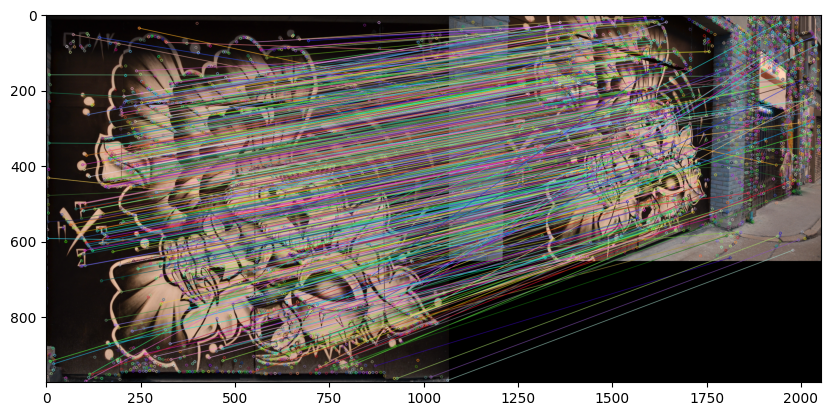

Number of all Matches:214, ROCC: 0.32473444613050073


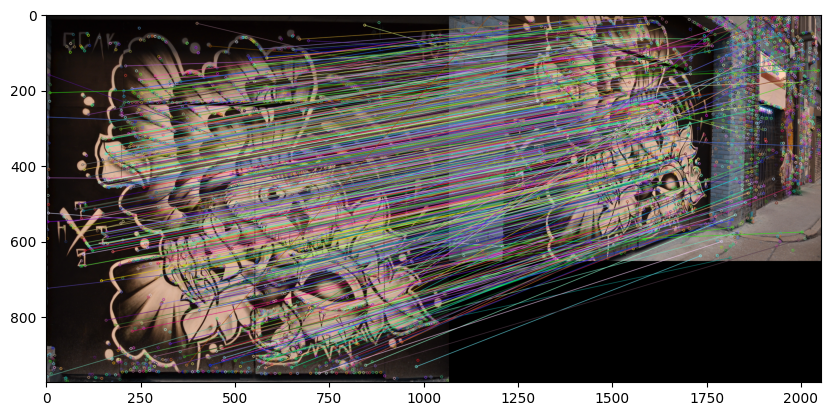

Number of all Matches:185, ROCC: 0.31951640759930916


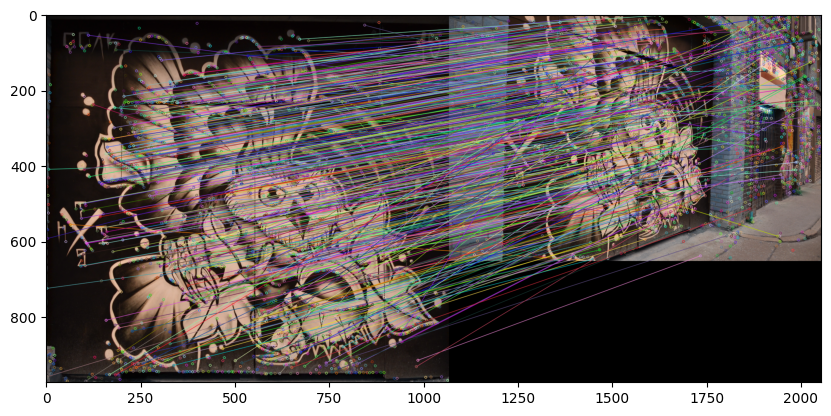

Number of all Matches:76, ROCC: 0.16521739130434782
Without outlier removal


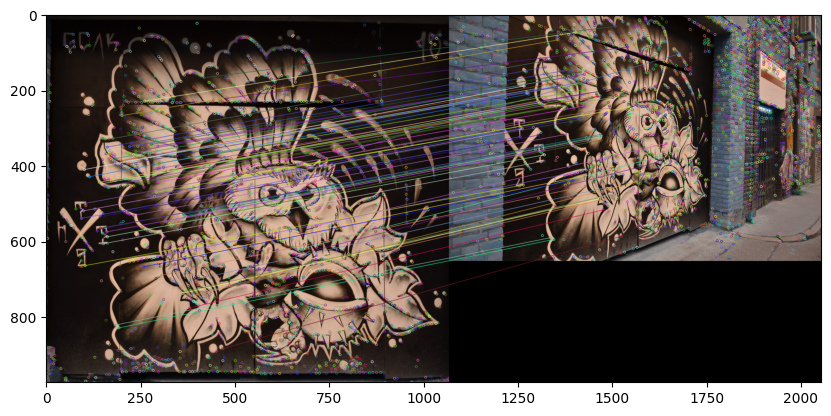

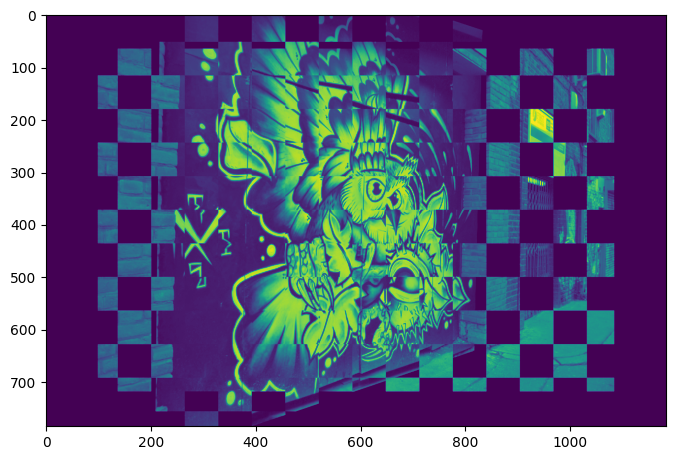

With outlier removal


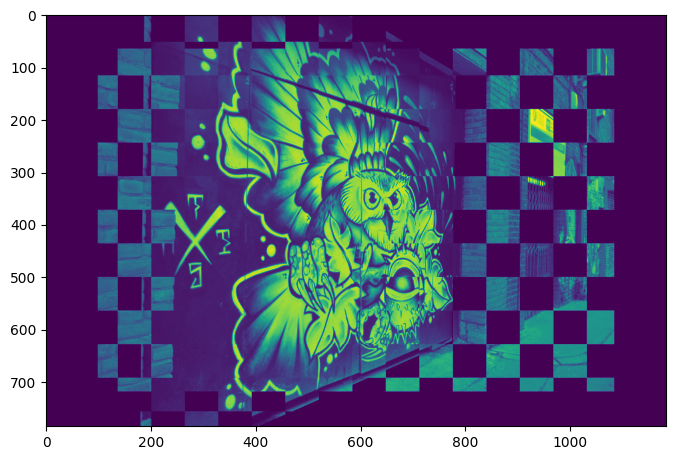

Number of all Matches:54, ROCC: 0.75


In [13]:
evaluation(net, test_img1, test_img2, verbose=True)

In [14]:
random.shuffle(training_data_base)
mean_loss = []
for epoch in tqdm(range(training_epochs)):
    for i, img_path in tqdm(enumerate(training_data_base),total=len(training_data_base)):
        try:
            img = Image.open(img_path)
            # if img is None: continue
            patch1, patch2, affine_tr =  get_random_affine_patches(img,patch_radius=patch_radius,)
            assert patch1.shape == patch2.shape
            patch1 = np.array(patch1.permute(1,2,0))
            patch2 = np.array(patch2.permute(1,2,0))
            
            preds = net.training_forward(patch1, patch2, affine_tr)
      
            kp1 = preds["keypoints1"].cpu().numpy()
            kp2 = preds["keypoints2"].cpu().numpy()
            desc1a, desc1b, desc1c = preds["descriptors1"]
            desc2a, desc2b, desc2c = preds["descriptors2"]
    
        
            kp1_projected =  ProjectiveTransform(np.linalg.inv(affine_tr.params))(kp1)
            
            dists = np.sum((kp1_projected[None, :, :] - kp2[:, None, :])**2,-1)
            matched_descs = np.argwhere(dists<.5)
            kkp1 = kp1[matched_descs[:, 1], :]
            kkp2 = kp2[matched_descs[:, 0], :]
            
            desc1a = desc1a[matched_descs[:, 1], :]
            desc1b = desc1b[matched_descs[:, 1], :]
            desc1c = desc1c[matched_descs[:, 1], :]
            
            desc2a = desc2a[matched_descs[:, 0], :]
            desc2b = desc2b[matched_descs[:, 0], :]
            desc2c = desc2c[matched_descs[:, 0], :]

            all_desc1 = torch.cat([desc1a,desc1b,desc1c])
            all_desc2 = torch.cat([desc2a,desc2b,desc2c])
            labels = torch.arange(len(all_desc1))

            all_desc = torch.cat([all_desc1, all_desc2])

            all_labels = torch.cat([labels, labels])
            
            loss_value =  loss_fn(all_desc, all_labels)
            loss_value.backward()
            
            mean_loss.append(loss_value)
           
            if i%batch_size==0:
                optimizer.step()
                optimizer.zero_grad()
                print("Mean Loss:", torch.mean(torch.tensor(mean_loss)))
                # print(torch.var(desc1a), torch.mean(desc1a))
                # print(torch.var(desc1b), torch.mean(desc2b))
                # print(torch.var(desc1c), torch.mean(desc2c))
                
                mean_loss = []
                evaluation(net, test_img1, test_img2)
                
        except KeyboardInterrupt:
            print('Interrupted')
            break
        except Exception as error:
            # Some patches are broken we're ignoring them 
            print("Bad patches: Ignoring this sample", error) 
            continue
    

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/95035 [00:00<?, ?it/s]

Mean Loss: tensor(0.9933)
Number of all Matches:233, ROCC: 0.3535660091047041
Number of all Matches:96, ROCC: 0.2096069868995633
Number of all Matches:70, ROCC: 0.14344262295081966
Number of all Matches:64, ROCC: 0.6956521739130435
Mean Loss: tensor(0.9852)
Number of all Matches:189, ROCC: 0.2867981790591806
Number of all Matches:73, ROCC: 0.17464114832535885
Number of all Matches:156, ROCC: 0.31388329979879276
Number of all Matches:83, ROCC: 0.7217391304347827
Mean Loss: tensor(0.9911)
Number of all Matches:214, ROCC: 0.32473444613050073
Number of all Matches:60, ROCC: 0.1348314606741573
Number of all Matches:114, ROCC: 0.23700623700623702
Number of all Matches:69, ROCC: 0.6699029126213593
Bad patches: Ignoring this sample Given groups=1, weight of size [16, 3, 3, 3], expected input[1, 1, 192, 192] to have 3 channels, but got 1 channels instead
Mean Loss: tensor(0.9918)
Number of all Matches:251, ROCC: 0.38088012139605465
Number of all Matches:82, ROCC: 0.18594104308390022
Number of a

In [15]:
torch.save(net.state_dict(), '/kaggle/working/saved_model')

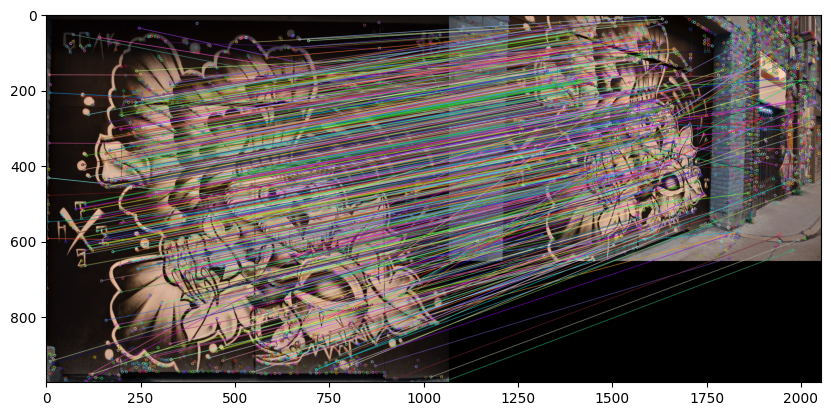

Number of all Matches:218, ROCC: 0.330804248861912


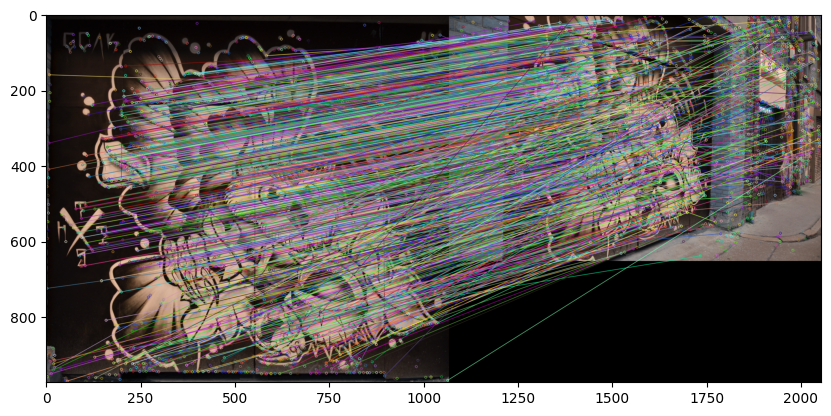

Number of all Matches:207, ROCC: 0.26169405815423513


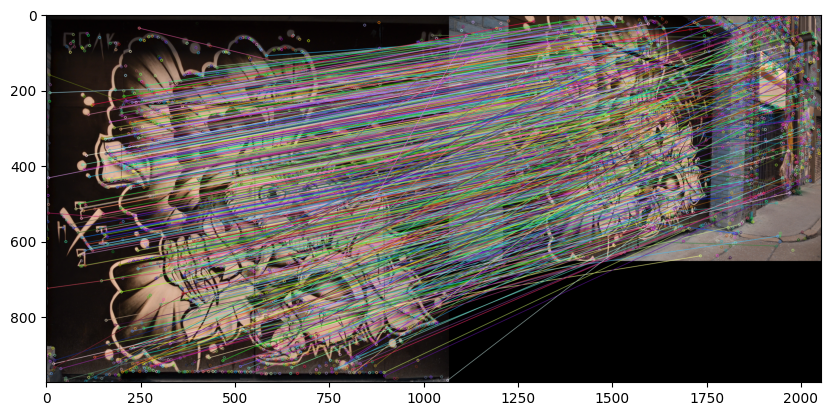

Number of all Matches:214, ROCC: 0.2625766871165644
Without outlier removal


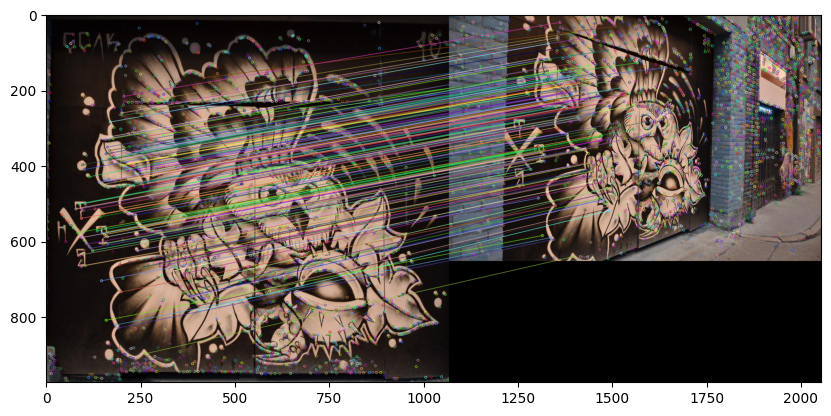

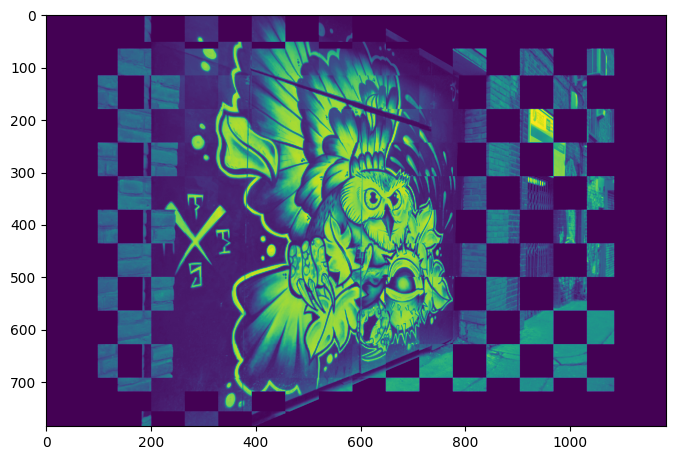

With outlier removal


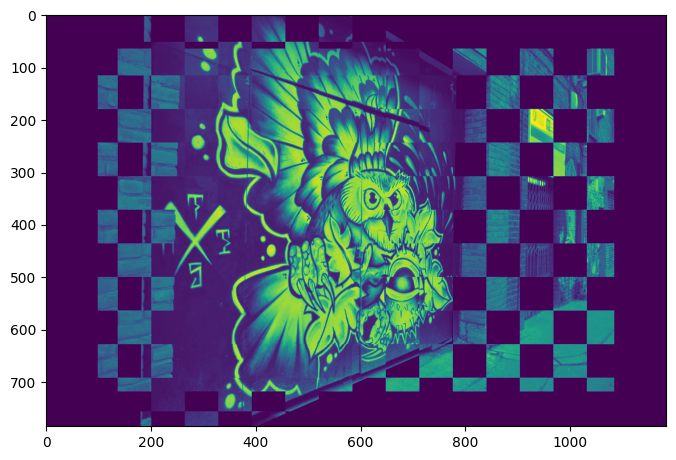

Number of all Matches:124, ROCC: 0.7209302325581395


In [16]:
evaluation(net, test_img1, test_img2, verbose=True)